In [26]:
import pandas as pd 
import numpy as np
import japanize_matplotlib
from sklearn import linear_model
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm,metrics

from sklearn.metrics import confusion_matrix # 混合行列
from sklearn.decomposition import PCA #主成分分析
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier # K近傍法
from sklearn.svm import SVC # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier # 決定木
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier # AdaBoost
from sklearn.naive_bayes import GaussianNB # ナイーブ・ベイズ
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# from sklearn.lda import LDA # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.metrics import f1_score, r2_score, classification_report
# from sklearn.qda import QDA # 二次判別分析
from seglearn.pipe import Pype
from seglearn.split import temporal_split
from seglearn.transform import FeatureRep, SegmentX
from seglearn.transform import SegmentXY, last, middle, mean
from seglearn.feature_functions import all_features, minimum, maximum,  mean,  std, kurt, mean_diff, median, willison_amplitude, variation
import seaborn as sns
import math
from matplotlib.font_manager import FontProperties
import random
import pickle

In [27]:
def blinkFix(data):
    print("start blinkFix--------------")
    # 瞬き認識
    blink = 0.7
    blinkArray = []
    for index, row in data.loc[data['eyeBlink'] > blink].iterrows():
            blinkArray.append(index)
   # 瞬きの始まりと終わり
    blinkStartIndexs = []
    blinkEndIndexs = []
    for i in range(len(blinkArray)):
        blinkStart = True
        blinkEnd = True
        if i - 1 >= 0:
            if blinkArray[i] - 1 == blinkArray[i-1]:
                blinkStart = False
        if i + 1 < len(blinkArray):
            if blinkArray[i] + 1 == blinkArray[i+1]:
                blinkEnd = False       
        if blinkStart:
            blinkStartIndexs.append(i)
        if blinkEnd:
            blinkEndIndexs.append(i) 
    blink_data = data.copy()
    startOffset = -5
    endOffset = 15
    for i in range(len(blinkStartIndexs)):
        blinkStartIndex = blinkArray[blinkStartIndexs[i]]
        blinkEndIndex = blinkArray[blinkEndIndexs[i]]
        if blinkStartIndex+startOffset < 0:
            blinkstart = 0
        else:
            blinkstart = blinkStartIndex+startOffset
        
        if blinkEndIndex+endOffset >= len(blink_data) :
            blinkend = len(blink_data)-1
        else:
            blinkend = blinkEndIndex+endOffset
        
        for j in range(blinkstart, blinkend):
            if j  >= 0 and  j < len(blink_data):
                d = blinkstart-blinkend
                ax = blink_data.iloc[blinkstart,:]['centerEyeLookAtPoint-x']-blink_data.iloc[blinkend,:]['centerEyeLookAtPoint-x']
                bx = blinkstart*blink_data.iloc[blinkend,:]['centerEyeLookAtPoint-x'] - blinkend*blink_data.iloc[blinkstart,:]['centerEyeLookAtPoint-x']
                ay = blink_data.iloc[blinkstart,:]['centerEyeLookAtPoint-y']-blink_data.iloc[blinkend,:]['centerEyeLookAtPoint-y']
                by = blinkstart*blink_data.iloc[blinkend,:]['centerEyeLookAtPoint-y'] - blinkend*blink_data.iloc[blinkstart,:]['centerEyeLookAtPoint-y']
                x = (ax*j + bx)/d
                y = (ay*j + by )/d
                blink_data.loc[blink_data.index == j, 'centerEyeLookAtPoint-x'] = x
                blink_data.loc[blink_data.index == j, 'centerEyeLookAtPoint-y'] = y
#      確認グラフ
#     beforFix = data.iloc[blinkArray[blinkStartIndexs[5]]-15:blinkArray[blinkEndIndexs[5]]+25,:].copy()
#     afterFix = blink_data.iloc[blinkArray[blinkStartIndexs[5]]-15:blinkArray[blinkEndIndexs[5]]+25,:].copy()
#     from matplotlib import pyplot as plt
#     plt.scatter(beforFix.index, beforFix['centerEyeLookAtPoint-x'], s=1, label="beforFix")
#     plt.scatter(afterFix.index, afterFix['centerEyeLookAtPoint-x'], s=1, label="afterFix")
#     plt.xticks(rotation=40)
#     plt.legend(loc="upper left", fontsize=14) 
#     plt.show()
    print("end blinkFix--------------")
    return blink_data

In [28]:
def dataInit(data):
    print("start dataInit--------------")
    #必要なデータ取り出し
    data['eyeBlink'] = (data['rightEyeBlink'] + data['leftEyeBlink'] )/2
    data = data[['timestamp', 'centerEyeLookAtPoint-x', 'centerEyeLookAtPoint-y',  'eyeBlink', 'operationType', 'operationPoint-x', 'operationPoint-y']].copy()
    blink_data = blinkFix(data)
    #キャリブレーション 
    target_x = blink_data.iloc[0,:]['operationPoint-x']
    target_y = blink_data.iloc[0,:]['operationPoint-y']
    for index, row in blink_data.iterrows():
        if target_x != row['operationPoint-x'] or target_y != row['operationPoint-y']:
            center_end = index-1
            break
    if center_end-150 < 0:
        print("center_end-150<0")
    else:
        center_start = center_end-150
    eyePointMean_x= blink_data.iloc[center_start:center_end,:]['centerEyeLookAtPoint-x'].mean()
    eyePointMean_y = blink_data.iloc[center_start: center_end,:]['centerEyeLookAtPoint-y'].mean()
    cal_x = target_x - eyePointMean_x
    cal_y = target_y - eyePointMean_y
    blink_data['centerEyeLookAtPoint-x'] = blink_data['centerEyeLookAtPoint-x'] + cal_x 
    blink_data['centerEyeLookAtPoint-y'] = blink_data['centerEyeLookAtPoint-y'] + cal_y 
#     centerキャリブレーションの確かめグラフ
#     cal_data = blink_data.iloc[center_start:center_end, :].copy()
#     data_ = data.iloc[center_start:center_end,:].copy()
#     plt.scatter(cal_data.index, cal_data['centerEyeLookAtPoint-y'], s=1, label="targetPoint-y(afterFix)")
#     plt.scatter(cal_data.index, cal_data['operationPoint-y'], s=1, label="operationPoint-x")
#     plt.scatter(data_.index, data_['centerEyeLookAtPoint-y'], s=1, label="targetPoint-y(beforFix)")
#     plt.xticks(rotation=40)
#     plt.legend(loc="upper left", fontsize=14) 
#     plt.show()
    #分類に使用するデータ     
    print("end dataInit--------------")
    return blink_data.iloc[center_end+1:, :]

In [29]:
# 画面をsplitx×splityに分割してカラム名columnにラベル付（0は例外）
# data:ラベル付をするdataframe
# column:ラベル付するカラム名
# splitx,splity:画面を分割する数
# shift:nextColumnをどれだけずらすか（プラス）
def coordinate_split(data, column, splitx, splity, shift):
    print("start coordinate_split--------------")
    X = 414
    Y = 896
    x_d = X/splitx
    y_d = Y/splity
    data[column] = 0
    labelWidth = 5#ラベル付の幅
    
#     columnにラベル付
    for index, row in data.iterrows():
        if(row['operationPoint-x'] != 0 and row['operationPoint-y'] != 0):
            label =  splitx * (math.floor(row['operationPoint-y']/y_d)) + math.floor(row['operationPoint-x']/x_d)+1
            data.loc[data.index == index, column] = label
    print("finish 1/3")
    
#     nextColumnとintentionにラベル付
    nextColumn = 'next' + column
    data[nextColumn] = 0
    intention = 'bef' + column
    data[intention] = 0
    for index, row in data.iterrows():
        if index < len(data)-1:
#             #column（分類したい操作位置）が変わる時
#             #かつ，次のcolumnが0ではない時（columnが0の時は操作をしていないか，例外） 
            if data.at[index, column] != data.at[index+1,column] and data.at[index+1, column] != 0:
                data.at[index, nextColumn] = data.at[index+1, column]
                for i in range(index-(labelWidth-1), index+1):
                    if i >= 0 and i < len(data):
                        data.at[i, intention] = 1
#                 print("column:{0}, nextcolumn:{1}".format(data.at[index, nextColumn], data.iloc[index+1,:][column]))
    print("finish 2/3")
    
#     intentionにラベル付
#     操作の意図があるかどうかを0，１でラベル付(本当は，座標が変わるごとにラベル付，今はColumnが変わるごと)
#     data.loc[data[nextColumn] != 0, intention] = 1
    print("finish 3/3")
    print("end coordinate_split--------------")

In [30]:
def ope_segment(data, width, segmentx, segmenty):
    print("start ope_segment--------------")
    shift = 5
    for index, row in data.iterrows():
        if index+1 < len(data):
            if row['operationType']  != data.iloc[index+1,:]['operationType'] and data.iloc[index+1,:]['operationType'] != 'none':
                 for i in range(index-shift-1, index+1):
                    data_ = data.iloc[i-(width-1): i+1,:].copy()
                    segmentx.append(data_[['centerEyeLookAtPoint-x', 'centerEyeLookAtPoint-y']].values)
                    segmenty.append(data.iloc[index+1,:]['operationType'])
                    
    editTextList = [i for i, x in  enumerate(segmenty) if 'editTextFild' in x]
    for j in editTextList:
        segmenty[j] = "editTextFIeld"

In [31]:
# セグメンテーション，操作前を一定フレームごとに分割
# width:何フレームでセグメントするか
# segmentIx = []，segmentIy = []（操作直前か，そうでないかの分類用）（直前の場合）
# segmentx = []，segmenty = []（操作直前の操作座標の全てのラベルの分類用）
# intention:操作直前のラベル付がされたカラム名
# nextColumn:操作座標のラベル付がされたカラム名
# labelNum:操作座標が何分割されているか
def segmentation(data, width, segmentIx, segmentIy, segmentx, segmenty, intention, nextColumn):
    print("start segmentation--------------")
    # segmentのwidth
    shift = 5
    for index, row in data.iterrows():
        if index >= width-1and index < len(data)-1:
            data_ = data.iloc[index-(width-1):index+1,:].copy()
            segmentIx.append(data_[['centerEyeLookAtPoint-x', 'centerEyeLookAtPoint-y']].values)
            segmentIy.append(row[intention])
            if row[nextColumn] != 0:
                for i in range(index-shift-1, index+1):
                    data_ = data.iloc[i-(width-1): i+1,:].copy()
                    segmentx.append(data_[['centerEyeLookAtPoint-x', 'centerEyeLookAtPoint-y']].values)
                    segmenty.append(row[nextColumn])
    print(len(segmentx))     
    print("end segmentation--------------")

In [32]:
# セグメントのラベル数を揃える
def adjust_segment(segmentIx, segmentIy, segmentx, segmenty):
    print("start adjust_segment--------------")
    onelist = [i for i, x in enumerate(segmentIy) if x == 1]
    zerolist = [j for j, y in enumerate(segmentIy) if y == 0]
    random.shuffle(zerolist)
    dI = len(zerolist)-len(onelist)
    print("onelist: {0}, zerolist: {1}, dI: {2}".format(len(onelist), len(zerolist), dI))
    zerolist_ = zerolist[:dI]
    print("zerolist_:{0}".format(len(zerolist_)))
    for k in sorted(zerolist_, reverse=True):
        segmentIy.pop(k)
        segmentIx.pop(k)
    print("finish 1/2")           
    print("min:{0}, max:{1}".format(min(segmenty), max(segmenty)))
    countlist = [0]*max(segmenty)
    for l in range(len(segmenty)):
        countlist[segmenty[l]-1] += 1   
    countmin = min(countlist)
    print(countmin) 
    for l in range(len(countlist)):
        if countlist[l] > countmin:
            indexlist = [m for m, z in enumerate(segmenty) if z == l+1]
            random.shuffle(indexlist)
            d = countlist[l] - countmin
            indexlist_ = indexlist[:d]
            for n in sorted(indexlist_, reverse=True):
                segmenty.pop(n)
                segmentx.pop(n)
    print(len(segmentx))
    print(len(segmenty))
    print("finish 2/2")
    print("end adjust_segment--------------")

In [61]:
def heatmap(clf, segmentx, segmenty):
    y, y_p = clf.transform_predict(segmentx, segmenty)
    labels = sorted(list(set(y)))
    cm_ = confusion_matrix(y,  y_p, labels=labels)
    cm = cm_.astype(np.float32)
    for i in range(len(cm)):
        sum = 0
        for j in range(len(cm[0])):
            sum += cm[i][j]
        cm[i] = (cm[i]*100)/sum
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    sns.heatmap(cm, cmap='Blues', annot=True, fmt='.1f', vmin=0, vmax=100)
    plt.xlabel('予測ラベル')
    plt.ylabel('正解ラベル')
    plt.tight_layout()
    plt.rcParams["font.size"] = 10
    plt.rcParams['figure.figsize'] = (7.0, 6.0)
    plt.show()

In [34]:
# モデルの学習
# fts：特徴量（配列）
# classifer：モデル
# labelCount：1つのラベルの数
def calssification(fts, classifier, segmentIx, segmentIy):
    clf = Pype([
                    ('features', FeatureRep(features=fts)),  # extracts features
                    ('rf', classifier)  #  ML algorithm of sklearn
                ])

    print(clf)
    segmentIx = np.array(segmentIx)
    X = segmentIx
    Y = segmentIy
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)
    print("count of data:", len(segmentIx))

    # # fit and score
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print("score of test data：", score)
    score = clf.score(X_train, y_train)
    print("score of train data：", score)
    score = clf.score(X, Y)
    print("score of all data：", score)
    
    heatmap(clf, X_test, y_test)
    
    return clf

In [35]:
def ftsScore(fts_name, fts_name_, fts_, classifier, segmentIx, segmentIy):
    # 自分でセグメンテーションする場合（操作直前かそうでないか）
    segmentIx = np.array(segmentIx)
    X = segmentIx
    Y = segmentIy
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)
    result = []
    for i in range(len(fts_name)):
        fts = {fts_name[i]: fts_[i]}
        clf = Pype([
                        ('features', FeatureRep(features=fts)),  # extracts features
                        ('rf', RandomForestClassifier(n_estimators=20))  #  ML algorithm of sklearn
                    ])

        clf.fit(X_train, y_train)
        score1 = clf.score(X_train, y_train)
        score2 = clf.score(X_test, y_test)
        result.append([score1, score2])
    df_result = pd.DataFrame(result, columns=['train', 'test'], index=fts_name_).sort_values('test', ascending=False)
    plt.rcParams["font.size"] = 18
    df_result.plot(kind='bar', alpha=0.5, grid=True)
    return clf

In [36]:
# 視線と操作座標の距離の確認用
def demoSeg(data, width, segment, column):
    # segmentのwidth
    shift = width
    for index, row in data.iterrows():
        if index < len(data)-1 and index > shift:
            #column（分類したい操作位置）が変わる時
            #かつ，次のcolumnが0ではない時（columnが0の時は操作をしていないか，例外） 
            if row[column] != data.iloc[index+1,:][column] and data.iloc[index+1,:][column] != 0:
                #next columnを追加
                data_ = data.loc[index-(shift-2):index+1,:].copy()
                dist_ = (data_['centerEyeLookAtPoint-x']-data.iloc[index+1,:]['operationPoint-x'])**2 + (data_['centerEyeLookAtPoint-y']-data.iloc[index+1,:]['operationPoint-y'])**2
                dist = np.sqrt(dist_)              
                data_['distance'] = dist
                opeDist_ = (data_['operationPoint-x']-data.iloc[index+1,:]['operationPoint-x'])**2 + (data_['operationPoint-y']-data.iloc[index+1,:]['operationPoint-y'])**2
                opeDist = np.sqrt(opeDist_)              
                data_['opeDistance'] = opeDist
                data_['nextOpePoint-x'] = data.iloc[index+1,:]['operationPoint-x']
                data_['nextOpePoint-y'] = data.iloc[index+1,:]['operationPoint-y']
                segment.append(data_[['centerEyeLookAtPoint-x', 'centerEyeLookAtPoint-y', 'operationPoint-x', 'operationPoint-y', 'distance', 'opeDistance', 
                                      'nextOpePoint-x', 'nextOpePoint-y']])

In [37]:
# データの事前処理
# mode：セグメントモード(0：学習時，1：予測時)
# csv_data_s：csvデータ(dataframe)の配列
# column：操作座標ラベルのカラム名
# splitx，splity：画面分割数
# shift：ラベルをずらす数
# width：セグメントの幅
def pre_processing(mode, csv_data_s, column, segmentIx, segmentIy, segmentx, segmenty, splitx, splity, shift, width):
    beforColumn = 'bef' + column
    nextColumn = 'next' + column
    data = pd.DataFrame(index=[])
    for csv_data_ in csv_data_s:
        initData = dataInit(csv_data_)
        coordinate_split(initData, column, splitx, splity, shift)
        segmentation(initData, width, segmentIx, segmentIy, segmentx, segmenty, beforColumn, nextColumn)
        data = pd.concat([data, initData])
    data = data.reset_index(drop=True)
    if mode == 0:
        adjust_segment(segmentIx, segmentIy, segmentx, segmenty)
    return data

In [50]:
# データ処理
csv_data1_ = pd.read_csv('./csvFile/saki/saki_2020121207472066200_map.csv')
csv_data2_ = pd.read_csv('./csvFile/saki/saki_2020121208192989900_map.csv')
csv_data3_ = pd.read_csv('./csvFile/saki/saki_2020121213393617800_map.csv')
csv_data4_ = pd.read_csv('./csvFile/saki/saki_2020121807375246400_map.csv')
csv_data_s = [csv_data1_, csv_data2_, csv_data3_]
segmentIx1 = []
segmentIy1 = []
segmentx1 = []
segmenty1 = []
data1 = pre_processing(1, csv_data_s, 'opClass', segmentIx1, segmentIy1, segmentx1, segmenty1, 4, 7, 0, 150)
data1

count of data：29570
clfI1_score: 0.6900574907000339
29570


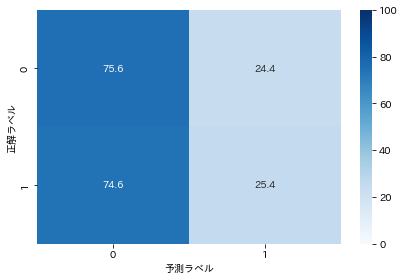

In [38]:
# 保存したモデルをロードする
filename = './model/home_clfI1.sav'
home_clfI1 = pickle.load(open(filename, 'rb'))
scoreI = home_clfI1.score(segmentIx1, segmentIy1)
print("count of data：{0}".format(len(segmentIy1)))
print("clfI1_score: {0}".format(scoreI))
heatmap(home_clfI1, segmentIx1, segmentIy1)

count of data：6258
clf1_score: 0.031639501438159155


<ipython-input-61-a17b512ce3b6>:10: RuntimeWarning: invalid value encountered in true_divide
  cm[i] = (cm[i]*100)/sum


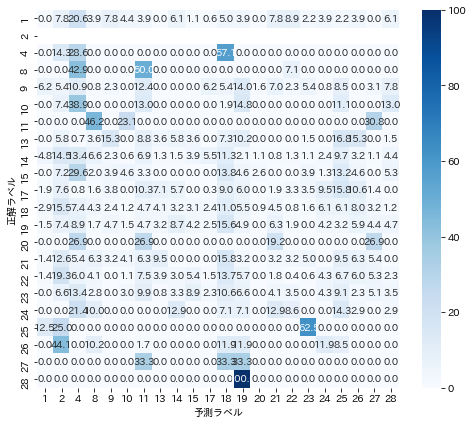

In [65]:
filename = './model/home_clf1.sav'
home_clf1 = pickle.load(open(filename, 'rb'))
score = home_clf1.score(segmentx1, segmenty1)
print("count of data：{0}".format(len(segmenty1)))
print("clf1_score: {0}".format(score))
heatmap(home_clf1, segmentx1, segmenty1)

In [40]:
segmentIx2 = []
segmentIy2 = []
segmentx2 = []
segmenty2 = []
data2 = pre_processing(1, csv_data_s, 'opClass2', segmentIx2, segmentIy2, segmentx2, segmenty2, 2, 2, 0, 150)

start dataInit--------------
start blinkFix--------------
end blinkFix--------------
end dataInit--------------
start coordinate_split--------------
finish 1/3
finish 2/3
finish 3/3
end coordinate_split--------------
start segmentation--------------
1162
end segmentation--------------
start dataInit--------------
start blinkFix--------------
end blinkFix--------------
end dataInit--------------
start coordinate_split--------------
finish 1/3
finish 2/3
finish 3/3
end coordinate_split--------------
start segmentation--------------
2555
end segmentation--------------
start dataInit--------------
start blinkFix--------------
end blinkFix--------------
end dataInit--------------
start coordinate_split--------------
finish 1/3
finish 2/3
finish 3/3
end coordinate_split--------------
start segmentation--------------
3675
end segmentation--------------


count of data：29570
clfI1_score: 0.7914102130537707


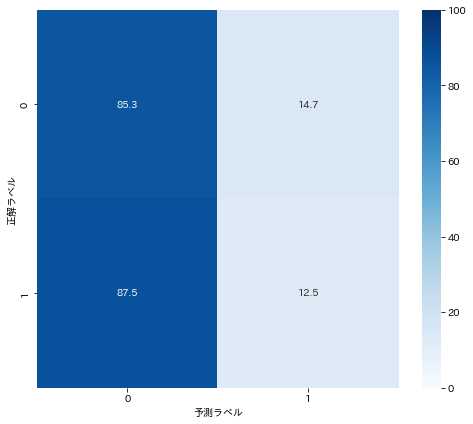

In [66]:
# 保存したモデルをロードする
filename = './model/home_clfI2.sav'
home_clfI2 = pickle.load(open(filename, 'rb'))
scoreI = home_clfI2.score(segmentIx2, segmentIy2)
print("count of data：{0}".format(len(segmentIy2)))
print("clfI1_score: {0}".format(scoreI))
heatmap(home_clfI2, segmentIx2, segmentIy2)

count of data：3675
clfI1_score: 0.23374149659863946


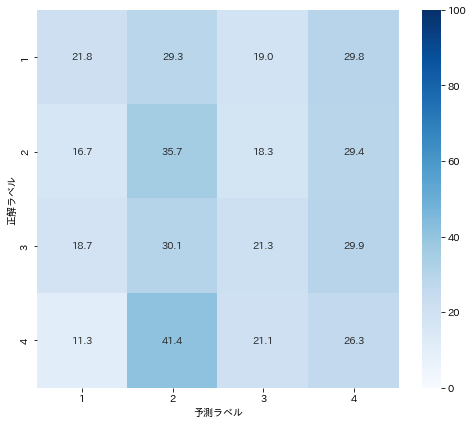

In [67]:
# 保存したモデルをロードする
filename = './model/home_clf2.sav'
home_clf2 = pickle.load(open(filename, 'rb'))
scoreI = home_clf2.score(segmentx2, segmenty2)
print("count of data：{0}".format(len(segmenty2)))
print("clfI1_score: {0}".format(scoreI))
heatmap(home_clf2, segmentx2, segmenty2)

In [52]:
def pre_processing(mode, csv_data_s, segmentx, segmenty, width):
    data = pd.DataFrame(index=[])
    for csv_data_ in csv_data_s:
        initData = dataInit(csv_data_)
        ope_segment(initData, width, segmentx, segmenty)
        data = pd.concat([data, initData])
    data = data.reset_index(drop=True)
    if mode == 0:
        adjust_segment(segmentx, segmenty)
    return data

# セグメントのラベル数を揃える
def adjust_segment(segmentx, segmenty):     
    print("min:{0}, max:{1}".format(min(segmenty), max(segmenty)))
    countlist = {}
    for i in range(len(segmenty)):
        if segmenty[i] in countlist:
            countlist[segmenty[i]] += 1
        else:
            countlist[segmenty[i]] = 1
        
    countmin = countlist[min(countlist)]
    print(countmin) 
    for key, val in countlist.items():
        if val > countmin:
            print("key:{0}, val:{1}".format(key, val))
            indexlist = [m for m, z in enumerate(segmenty) if z == key]
            random.shuffle(indexlist)
            d = countlist[key] - countmin
            indexlist_ = indexlist[:d]
            for n in sorted(indexlist_, reverse=True):
                segmenty.pop(n)
                segmentx.pop(n)
    print(len(segmentx))
    print(len(segmenty))
    print("finish 2/2")
    print("end adjust_segment--------------")

# segx_ = []
# segy_ = []
# width = 150
# data = csv_data_s.copy()
# pre_processing(0, csv_data_s, segx_, segy_, width)

/Applications/anaconda3/envs/test/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass memory=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Applications/anaconda3/envs/test/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Pype(steps=[('features',
             FeatureRep(features={'max': <function maximum at 0x7fd3df1891f0>,
                                  'med': <function median at 0x7fd3df180b80>,
                                  'min': <function minimum at 0x7fd3df189160>})),
            ('rf', RandomForestClassifier(n_estimators=20))])
count of data: 2373
score of test data： 0.9764309764309764
score of train data： 0.9994378864530635
score of all data： 0.9936788874841972


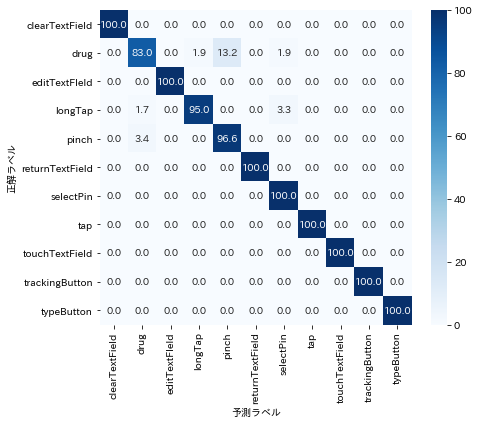

In [62]:
fts = {'min': minimum, 'max': maximum, 'med': median}
classifier = RandomForestClassifier(n_estimators=20)
ope_clf = calssification(fts, classifier, segx_, segy_)

start dataInit--------------
start blinkFix--------------
end blinkFix--------------
end dataInit--------------
start ope_segment--------------
min:drug, max:trackingButton
12138
29848
29848
finish 2/2
end adjust_segment--------------
count of data：29848
clfI1_score: 0.49333288662556957


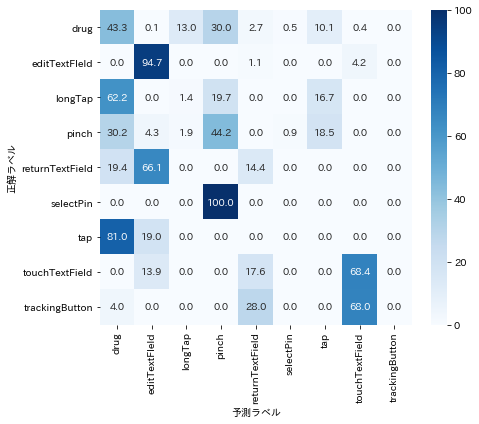

In [63]:
segx = []
segy = []
width = 150
csv_datas_ = [csv_data4_]
pre_processing(0, csv_datas_, segx, segy, width)
scoreI = ope_clf.score(segx, segy)
print("count of data：{0}".format(len(segy)))
print("clfI1_score: {0}".format(scoreI))
heatmap(ope_clf, segx, segy)

['pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 'pinch', 